In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from pylab import rcParams
import statsmodels.api as sm
import warnings
import itertools
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
df=pd.read_excel('/content/drive/MyDrive/기계학습/종합파일.xlsx', index_col=0)
df

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,날짜,종가,시가,고가,저가,거래량,변동률
0,1983-03-31,29.27,29.40,29.60,29.25,0.52,-0.44
1,1983-04-04,29.44,29.30,29.70,29.29,0.16,0.58
2,1983-04-05,29.71,29.50,29.80,29.50,0.18,0.92
3,1983-04-06,29.90,29.90,29.92,29.65,0.39,0.64
4,1983-04-07,30.17,29.92,30.20,29.86,0.82,0.90
...,...,...,...,...,...,...,...
9928,2022-05-18,109.59,113.66,115.42,108.46,103.67,-2.50
9929,2022-05-19,112.21,109.09,112.62,105.13,68.51,2.39
9930,2022-05-20,113.23,111.45,114.04,110.85,20,0.91
9931,2022-05-22,110.31,110.56,110.56,109.53,-,-2.58


In [2]:
df

,날짜,종가,시가,고가,저가,거래량,변동률
0,1983-03-31,29.27,29.40,29.60,29.25,0.52,-0.44
1,1983-04-04,29.44,29.30,29.70,29.29,0.16,0.58
2,1983-04-05,29.71,29.50,29.80,29.50,0.18,0.92
3,1983-04-06,29.90,29.90,29.92,29.65,0.39,0.64
4,1983-04-07,30.17,29.92,30.20,29.86,0.82,0.90
...,...,...,...,...,...,...,...
9928,2022-05-18,109.59,113.66,115.42,108.46,103.67,-2.50
9929,2022-05-19,112.21,109.09,112.62,105.13,68.51,2.39
9930,2022-05-20,113.23,111.45,114.04,110.85,20,0.91
9931,2022-05-22,110.31,110.56,110.56,109.53,-,-2.58


In [3]:
df= df.set_index("날짜")

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0, flags=flags)


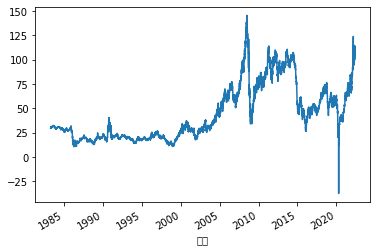

In [5]:
df['종가'].plot()

In [8]:
wti=df[['종가']]

In [9]:
wti['2019':]

,종가
날짜,
2019-01-01,45.89
2019-01-02,46.54
2019-01-03,47.09
2019-01-04,47.96
2019-01-07,48.52
...,...
2022-05-18,109.59
2022-05-19,112.21
2022-05-20,113.23


In [10]:
def ts_train_test(wti, time_steps, for_periods): 
    """
    input:
     data: dataframe with dates and price data
    output:
     X_train, y_train: data from 2013/1/1-2018-12/31 
     X_test : data from 2019 - 
    time_steps: # of the input time steps 
    for_periods: # of the output time steps 
    """
    # create training and test set 
    ts_train = wti[:'2019'].iloc[:,0:1].values
    ts_test = wti['2020':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)
    
    # create training data of s samples and t time steps 
    X_train = [] 
    y_train = [] 
    y_train_stacked = [] 
    for i in range(time_steps, ts_train_len - 1): 
        X_train.append(ts_train[i-time_steps:i,0])
        y_train.append(ts_train[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    # Reshapng X_train for efficient modelling 
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
    
    # Preparing to creat X_test 
    inputs = pd.concat((wti["종가"][:'2019'], wti["종가"]['2020':]), axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    
    X_test = []
    for i in range(time_steps, ts_test_len+ time_steps- for_periods):
        X_test.append(inputs[i-time_steps:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
    
    return X_train, y_train, X_test 

X_train, y_train, X_test = ts_train_test(wti,5,2)
X_train.shape[0], X_train.shape[1]


(9297, 5)

In [11]:
# Convert the 3D shape of X_train to a data frame so we can see: 
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0], X_train.shape[1])))
y_train_see = pd.DataFrame(y_train)
pd.concat([X_train_see, y_train_see], axis = 1)

# Convert the 3D shape of X_test to a data frame so we can see: 
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0], X_test.shape[1])))
pd.DataFrame(X_test_see)

print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")



There are 9297 samples in the training data
There are 628 samples in the test data


In [13]:
def ts_train_test_normalize(all_data, time_steps, for_periods):
    """
    input: 
        data: dataframe with dates and price data
    output: 
        X_train, y_train: data from 2013/1/1-2018/12/31 
        X_test : data from 2019- 
        sc :     insantiated MinMaxScaler object fit to the training data 
    """
    # create training and test set 
    ts_train = all_data[:'2019'].iloc[:,0:1].values
    ts_test = all_data['2020':].iloc[:,0:1].values 
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)
    
    # scale the data 
    from sklearn.preprocessing import MinMaxScaler 
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)
    
    # create training data of s samples and t time steps 
    X_train = [] 
    y_train = [] 
    for i in range(time_steps, ts_train_len-1):
        X_train.append(ts_train_scaled[i-time_steps:i, 0])
        y_train.append(ts_train_scaled[i:i+for_periods, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    # Reshaping X_train for efficient modelling 
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1 ))
    
    inputs = pd.concat((df["종가"][:'2019'], all_data["종가"]['2020':]), axis=0).values
    inputs = inputs[len(inputs)-len(ts_test)-time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)
    
    # Preparing X_test 
    X_test = [] 
    for i in range(time_steps, ts_test_len + time_steps - for_periods):
        X_test.append(inputs[i-time_steps:i,0])
    
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    return X_train, y_train , X_test, sc 

## Simple RNN model

(4189.7207, <matplotlib.axes._subplots.AxesSubplot at 0x7f3200587b90>)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text

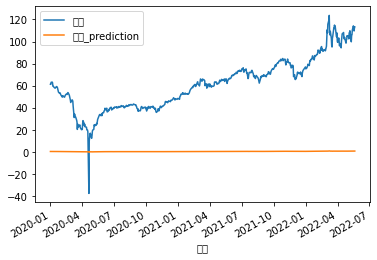

In [16]:
def simple_rnn_model(X_train, y_train, X_test):
    """
    create single layer rnn model trained on X_train and y_train 
    and make predictions on the X_test data 
    """
    # create a model 
    from keras.models import Sequential 
    from keras.layers import Dense, SimpleRNN 
    
    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32, return_sequences = True))
    my_rnn_model.add(SimpleRNN(32))
    my_rnn_model.add(Dense(2)) # The time step of the output 
    
    my_rnn_model.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
    
    # fit the RNN model 
    my_rnn_model.fit(X_train,y_train, epochs = 100, batch_size = 150, verbose = 0) 
    
    # Finalizing predictions 
    rnn_predictions = my_rnn_model.predict(X_test)
    
    return my_rnn_model, rnn_predictions

my_rnn_model, rnn_predictions = simple_rnn_model(X_train, y_train, X_test)
rnn_predictions[1:10]

def actual_pred_plot(preds):
    """
    Plot the actual vs predition
    """
    actual_pred = pd.DataFrame(columns = ['종가', '종가_prediction'])
    actual_pred['종가'] = df.loc['2020':,'종가'][0:len(preds)]
    actual_pred['종가_prediction'] = preds[:,0]
    
    from keras.metrics import MeanSquaredError 
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['종가']), np.array(actual_pred['종가_prediction']))
    
    return (m.result().numpy(), actual_pred.plot())

actual_pred_plot(rnn_predictions)

## 정규화된 데이터로 RNN

(13.692608, <matplotlib.axes._subplots.AxesSubplot at 0x7f320187df90>)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text

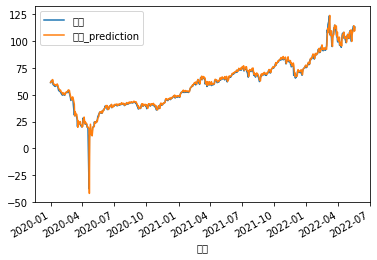

In [15]:
def actual_pred_plot(preds):
    """
    Plot the actual vs predition
    """
    actual_pred = pd.DataFrame(columns = ['종가', '종가_prediction'])
    actual_pred['종가'] = df.loc['2020':,'종가'][0:len(preds)]
    actual_pred['종가_prediction'] = preds[:,0]
    
    from keras.metrics import MeanSquaredError 
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['종가']), np.array(actual_pred['종가_prediction']))
    
    return (m.result().numpy(), actual_pred.plot())
def simple_rnn_model(X_train, y_train, X_test, sc):
    """
    create single layer rnn model trained on X_train and y_train 
    and make predictions on the X_test data 
    """
    # create a model 
    from keras.models import Sequential 
    from keras.layers import Dense, SimpleRNN 
    
    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32, return_sequences = True))
    my_rnn_model.add(SimpleRNN(32))
    my_rnn_model.add(Dense(2)) # The time step of the output 
    
    my_rnn_model.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
    
    # fit the RNN model 
    my_rnn_model.fit(X_train,y_train, epochs = 100, batch_size = 150, verbose = 0) 
    
    # Finalizing predictions 
    rnn_predictions = my_rnn_model.predict(X_test)
    from sklearn.preprocessing import MinMaxScaler 
    rnn_predictions = sc.inverse_transform(rnn_predictions)
    
    return my_rnn_model, rnn_predictions

X_train, y_train, X_test, sc = ts_train_test_normalize(df, 5,2)
my_rnn_model, rnn_predictions_2 = simple_rnn_model(X_train, y_train, X_test, sc)
rnn_predictions_2[1:10]
actual_pred_plot(rnn_predictions_2)

## LSTM

In [28]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Bidirectional
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
df=pd.read_excel('/content/drive/MyDrive/기계학습/종합파일.xlsx', index_col=0)
df

,날짜,종가,시가,고가,저가,거래량,변동률
0,1983-03-31,29.27,29.40,29.60,29.25,0.52,-0.44
1,1983-04-04,29.44,29.30,29.70,29.29,0.16,0.58
2,1983-04-05,29.71,29.50,29.80,29.50,0.18,0.92
3,1983-04-06,29.90,29.90,29.92,29.65,0.39,0.64
4,1983-04-07,30.17,29.92,30.20,29.86,0.82,0.90
...,...,...,...,...,...,...,...
9928,2022-05-18,109.59,113.66,115.42,108.46,103.67,-2.50
9929,2022-05-19,112.21,109.09,112.62,105.13,68.51,2.39
9930,2022-05-20,113.23,111.45,114.04,110.85,20,0.91
9931,2022-05-22,110.31,110.56,110.56,109.53,-,-2.58


In [32]:
#df= df.set_index("날짜")
from sklearn.preprocessing import MinMaxScaler

df.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['시가', '고가', '저가', '종가']
df_scaled = scaler.fit_transform(df[scale_cols])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

df_scaled

,시가,고가,저가,종가
0,0.272630,0.136367,0.379045,0.365734
1,0.272002,0.137101,0.379263,0.366663
2,0.273258,0.137835,0.380408,0.368139
3,0.275771,0.138716,0.381225,0.369178
4,0.275897,0.140771,0.382369,0.370654
...,...,...,...,...
9928,0.801935,0.766239,0.810613,0.804833
9929,0.773227,0.745688,0.792470,0.819156
9930,0.788052,0.756110,0.823635,0.824732
9931,0.782461,0.730569,0.816443,0.808769


In [33]:
TEST_SIZE = 200
WINDOW_SIZE = 20

train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [34]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [35]:
from sklearn.model_selection import train_test_split

feature_cols = ['시가', '고가', '저가']
label_cols = ['종가']

train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 20)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
x_train.shape, x_valid.shape

((7770, 20, 3), (1943, 20, 3))

In [36]:
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape

((200, 3), (200, 1))

In [37]:
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((180, 20, 3), (180, 1))

In [38]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))

In [39]:
import os

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                                    epochs=200, 
                                    batch_size=16,
                                    validation_data=(x_valid, y_valid), 
                                    callbacks=[early_stop, checkpoint])

Epoch 1/200
481/486 [============================>.] - ETA: 0s - loss: 0.0213
Epoch 1: val_loss improved from inf to 0.00011, saving model to model/tmp_checkpoint.h5
486/486 [==============================] - 7s 10ms/step - loss: 0.0211 - val_loss: 1.0740e-04
Epoch 2/200
482/486 [============================>.] - ETA: 0s - loss: 1.3763e-04
Epoch 2: val_loss did not improve from 0.00011
486/486 [==============================] - 4s 9ms/step - loss: 1.3704e-04 - val_loss: 1.1185e-04
Epoch 3/200
481/486 [============================>.] - ETA: 0s - loss: 1.3893e-04
Epoch 3: val_loss improved from 0.00011 to 0.00010, saving model to model/tmp_checkpoint.h5
486/486 [==============================] - 6s 12ms/step - loss: 1.3838e-04 - val_loss: 9.6858e-05
Epoch 4/200
485/486 [============================>.] - ETA: 0s - loss: 1.2576e-04
Epoch 4: val_loss improved from 0.00010 to 0.00009, saving model to model/tmp_checkpoint.h5
486/486 [==============================] - 6s 13ms/step - loss: 1.25

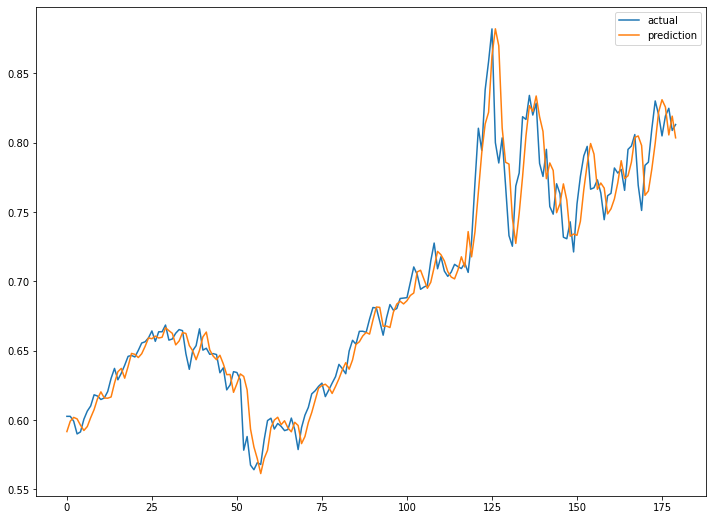

In [40]:
model.load_weights(filename)
pred = model.predict(test_feature)
pred.shape
plt.figure(figsize=(12, 9))
plt.plot(test_label, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()

In [42]:
data=df[['종가']]

##LSTM 다시...

In [43]:
from tensorflow.keras.layers import Dense, Input, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

nInput = 1
nOutput = 1
nStep = 20
nHidden = 50


In [44]:
def createTrainData(xData, step):
    m = np.arange(len(xData) - step)
    x, y = [], []
    for i in m:
        a = xData[i:(i+step)]
        x.append(a)
    xBatch = np.reshape(np.array(x), (len(m), step, 1))
    for i in m+1:
        a = xData[i:(i+step)]
        y.append(a[-1])
    yBatch = np.reshape(np.array(y), (len(m), 1))
    return xBatch, yBatch

x,y=createTrainData(data, nStep)
xInput = Input(batch_shape=(None, nStep, 1))
xLstm = LSTM(nHidden)(xInput)
xOutput = Dense(nOutput)(xLstm)
model = Model(xInput, xOutput)
model.compile(loss='mse', optimizer=Adam(lr=0.01))
# 학습한다
h = model.fit(x, y, epochs=100, batch_size=100, shuffle=True)
# 향후 20 기간 데이터를 예측한다. 향후 1 기간을 예측하고, 예측값을 다시 입력하여 2 기간을 예측한다.
# 이런 방식으로 20 기간까지 예측한다.
nFuture = 20
if len(data) > 100:
    lastData = np.copy(data[-100:])  # 원 데이터의 마지막 100개만 그려본다
else:
    lastData = np.copy(data)
dx = np.copy(lastData)
estimate = [dx[-1]]
for i in range(nFuture):
    # 마지막 nStep 만큼 입력데이로 다음 값을 예측한다
    px = dx[-nStep:].reshape(1, nStep, 1)
      # 다음 값을 예측한다.
    yHat = model.predict(px)[0][0]      
    # 예측값을 저장해 둔다
    estimate.append(yHat)
    # 이전 예측값을 포함하여 또 다음 값을 예측하기위해 예측한 값을 저장해 둔다
    dx = np.insert(dx, len(dx), yHat)
# Loss history를 그린다
plt.figure(figsize=(8, 4))
plt.plot(h.history['loss'], color='red')
plt.title("Loss History")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

# 원 시계열과 예측된 시계열을 그린다
ax1 = np.arange(1, len(lastData) + 1)
ax2 = np.arange(len(lastData), len(lastData) + len(estimate))
plt.figure(figsize=(8, 4))
plt.plot(ax1, lastData, 'b-o', color='blue', markersize=3, label='Time series', linewidth=1)
plt.plot(ax2, estimate, 'b-o', color='red', markersize=3, label='Estimate')
plt.axvline(x=ax1[-1],  linestyle='dashed', linewidth=1)
plt.legend()
plt.show()


KeyError: ignored

##XGBoost


In [ ]:
df=pd.read_excel('/content/drive/MyDrive/기계학습/종합파일.xlsx', index_col=0)
df
y_train = df['종가']
X_train.drop(['종가'],axis=1,inplace=True)

In [49]:
#df=df[['종가']]
from pandas import DataFrame
from pandas import concat
from xgboost import XGBRegressor
#from pandas_datareader import data as pdr
values=df.values
days_in=30
days_out=1
#Supervised Learning으로 변경
df=DataFrame(values)
raw=[]
for i in range(days_in, 0,-1):
  raw.append(df.shift(i))
for i in range(0, days_out):
  raw.append(df.shift(-i))
sum=concat(raw, axis=1)
sum.dropna(inplace=True)
train=sum.values

In [52]:
trainX, trainy=train[:,:-1], train[:, -1]
model=XGBRegressor(objective='reg:squarederror', n_estimators=80)
model.fit(trainX, trainy)
data_in=values[-(days_in):]
result=model.predict([data_in])

TypeError: ignored

##ARIMA

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df=pd.read_excel('/content/drive/MyDrive/기계학습/종합파일.xlsx', index_col=0)
df
df=df[['날짜','종가']]
df.columns = ["ds","y"]
df.head()

,ds,y
0,1983-03-31,29.27
1,1983-04-04,29.44
2,1983-04-05,29.71
3,1983-04-06,29.90
4,1983-04-07,30.17


In [59]:
df

,ds,y
0,1983-03-31,29.27
1,1983-04-04,29.44
2,1983-04-05,29.71
3,1983-04-06,29.90
4,1983-04-07,30.17
...,...,...
9928,2022-05-18,109.59
9929,2022-05-19,112.21
9930,2022-05-20,113.23
9931,2022-05-22,110.31


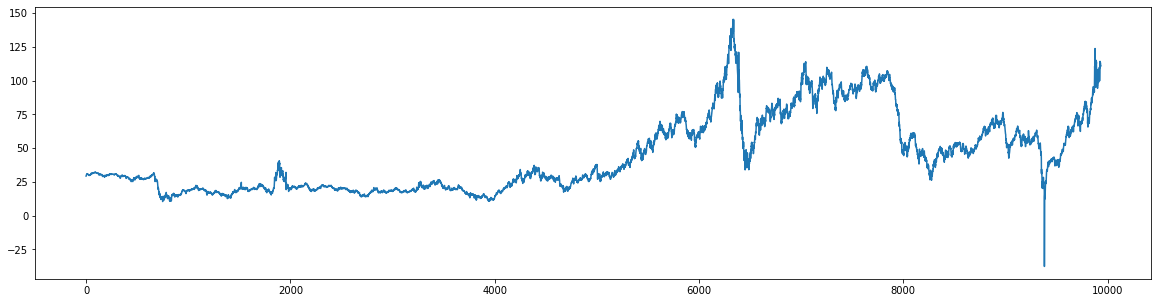

In [58]:
plt.figure(figsize=(20,5))
plt.plot(range(len(df["ds"])), df["y"])
plt.show()

In [60]:
df_train = df.iloc[:-2000]

<Figure size 432x288 with 0 Axes>

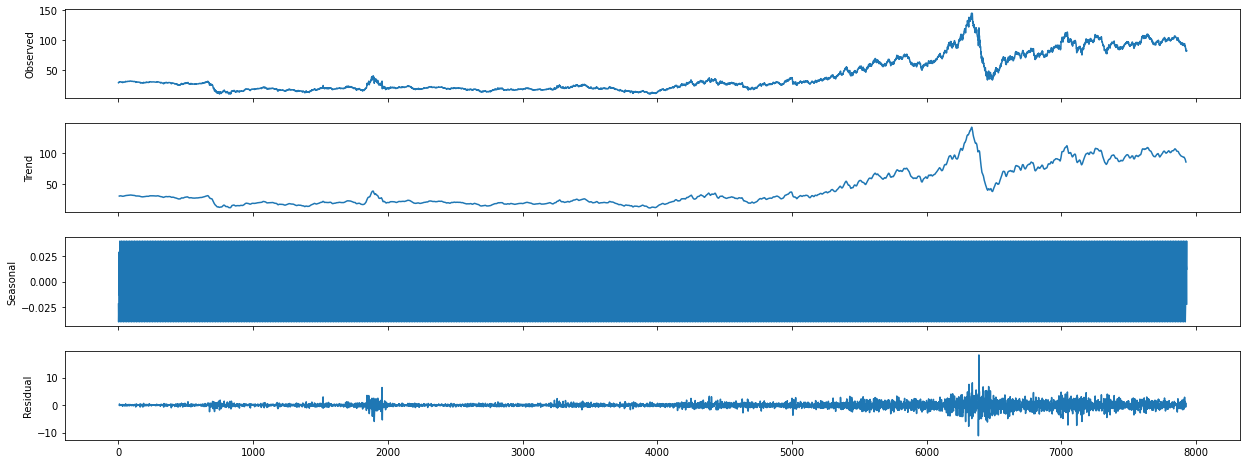

In [63]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_train["y"], model="additive", freq=12)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,7)
plt.show()

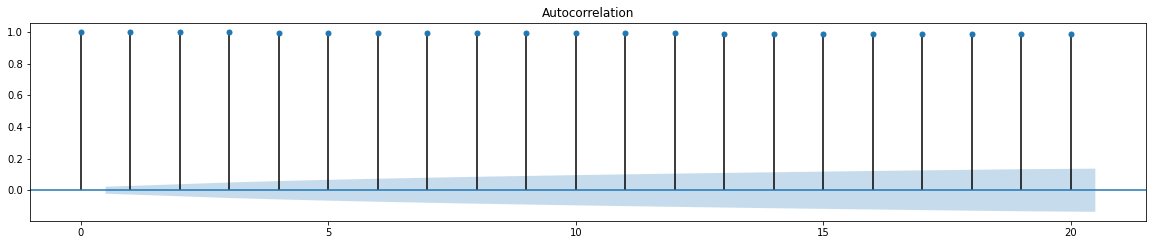

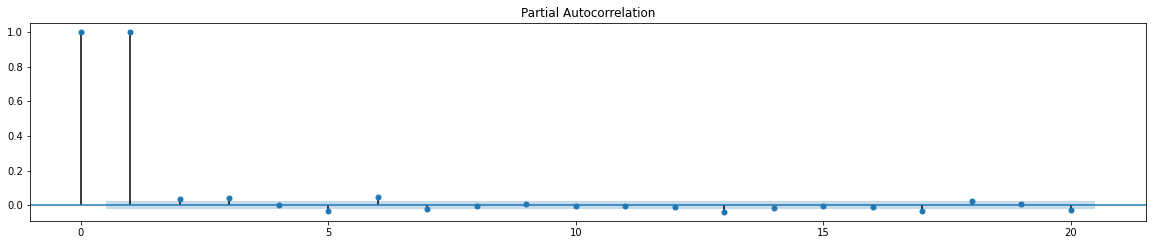

In [64]:
import statsmodels.api as sm
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_train["y"], lags=20, ax=ax1)

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_train["y"], lags=20, ax=ax1)

q=0,p=1

In [66]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from tqdm import tqdm

In [67]:
p = range(0,3)
d = range(1,2)
q = range(0,6)

pdq = list(itertools.product(p,d,q))

aic = []
params = []

with tqdm(total = len(pdq)) as pg:
    for i in pdq:
        pg.update(1)
        try:
            model = SARIMAX(df_train["y"], order=(i))
            model_fit = model.fit()
            aic.append(round(model_fit.aic,2))
            params.append((i))
        except:
            continue

 83%|████████▎ | 15/18 [00:21<00:05,  1.81s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
100%|██████████| 18/18 [00:40<00:00,  2.27s/it]


## 최적의 파라미터 (2,1,2)

In [68]:
optimal = [(params[i],j) for i,j in enumerate(aic) if j == min(aic)]
model_opt = ARIMA(df_train["y"], order = optimal[0][0])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 7932
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -11765.492
Method:                       css-mle   S.D. of innovations              1.066
Date:                Thu, 02 Jun 2022   AIC                          23542.984
Time:                        07:56:25   BIC                          23584.856
Sample:                             1   HQIC                         23557.322
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0067      0.012      0.571      0.568      -0.016       0.030
ar.L1.D.y      0.0661      0.025      2.610      0.009       0.016       0.116
ar.L2.D.y     -0.9561      0.012    -79.602      0.000      -0.980      -0.933
ma.L1.D.y     -0.0884      0.025     -3.500      0.000      -0.138      -0.039
ma.L2.D.y      0.9518      0.016     58.486      0.000       0.920       0.984
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0346           -1.0221j            1.0227           -0.2446
AR.2            0.0346           +1.0221j            1.0227            0.2446
MA.1            0.0465           -1.0240j            1.0250           -0.2428
MA.2            0.0465           +1.0240j            1.0250            0.2428
-----------------------------------------------------------------------------
"""

##LSTM

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df=pd.read_excel('/content/drive/MyDrive/기계학습/종합파일.xlsx', index_col=0)
df
df=df[['날짜','종가']]
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
df['종가']= min_max_scaler.fit_transform(df["종가"].to_numpy().reshape(-1,1))

In [96]:
train = df[:-1000]
train = train["종가"].to_numpy()

test = df[-1000:]
test = test["종가"].to_numpy()

In [101]:
test.size

1000

In [104]:
from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    def __init__(self, y, input_window, output_window, stride=1):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output : shape = (window 크기, sample 개수)
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

In [105]:
iw = 2000
ow = 1000

train_dataset = windowDataset(train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)

In [106]:
import torch
import torch.nn as nn
class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        lstm_out, self.hidden = self.lstm(x_input)
        return lstm_out, self.hidden

In [107]:
class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(-1), encoder_hidden_states)
        output = self.linear(lstm_out)
        
        return output, self.hidden

In [108]:
class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]

        outputs = torch.zeros(batch_size, target_len, input_size)

        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        
        #원하는 길이가 될 때까지 decoder를 실행한다.
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            
            # teacher forcing을 구현한다.
            # teacher forcing에 해당하면 다음 인풋값으로는 예측한 값이 아니라 실제 값을 사용한다.
            if random.random() < teacher_forcing_ratio:
                decoder_input = targets[:, t, :]
            else:
                decoder_input = out
            outputs[:,t,:] = out

        return outputs
	
    # 편의성을 위해 예측해주는 함수도 생성한다.
    def predict(self, inputs, target_len):
        self.eval()
        inputs = inputs.unsqueeze(0)
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]
        outputs = torch.zeros(batch_size, target_len, input_size)
        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            decoder_input = out
            outputs[:,t,:] = out
        return outputs.detach().numpy()[0,:,0]

In [109]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = lstm_encoder_decoder(input_size=1, hidden_size=16).to(device)


In [87]:
import torch.optim as optim
learning_rate=0.01
epoch = 3000
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

In [89]:
from tqdm import tqdm
import random
model.train()
with tqdm(range(epoch)) as tr:
    for i in tr:
        total_loss = 0.0
        for x,y in train_loader:
            optimizer.zero_grad()
            x = x.to(device).float()
            y = y.to(device).float()
            output = model(x, y, ow, 0.6).to(device)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().item()
        tr.set_postfix(loss="{0:.5f}".format(total_loss/len(train_loader)))

  0%|          | 11/3000 [23:01<104:17:05, 125.60s/it, loss=1820.68361]


KeyboardInterrupt: ignored

In [ ]:
predict = model.predict(torch.tensor(train[-1000*2:]).reshape(-1,1).to(device).float(), target_len=ow)
real = df["종가"].to_numpy()

predict = min_max_scaler.inverse_transform(predict.reshape(-1,1))
real = min_max_scaler.inverse_transform(real.reshape(-1,1))

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(range(1000,9933), real[1000:], label="real")
plt.plot(range(9933-1000,9933), predict[-1000:], label="predict")

plt.title("Test Set")
plt.legend()
plt.show()

In [ ]:
def MAPEval(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPEval(predict[-1000:],real[-1000:])